- Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
- Apply a distortion correction to raw images.
- Use color transforms, gradients, etc., to create a thresholded binary image.
- Apply a perspective transform to rectify binary image ("birds-eye view").
- Detect lane pixels and fit to find the lane boundary.
- Determine the curvature of the lane and vehicle position with respect to center.
- Warp the detected lane boundaries back onto the original image.
- Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

In [1]:
import glob
import cv2
import numpy as np
from tqdm import tqdm as tqdm
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

# Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.

### Load and display calibration images

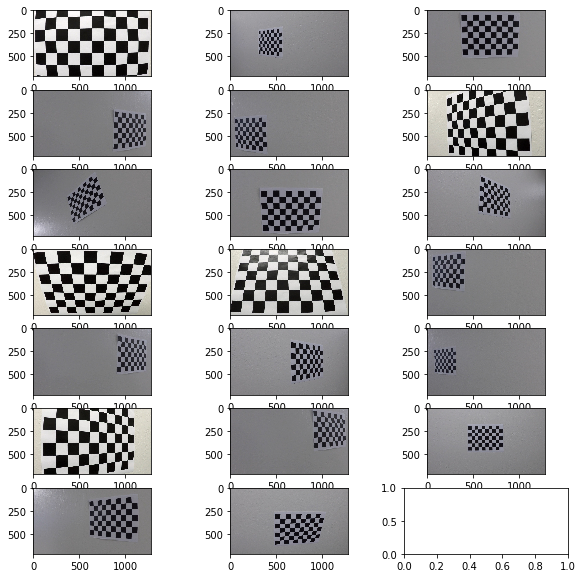

In [2]:
camera_cal_images = [mpimg.imread(f) for f in glob.glob('./camera_cal/*.jpg')]
fig, ax = plt.subplots(nrows=len(camera_cal_images)//3+1, ncols=3, figsize=(10,10))
ax = ax.reshape(-1)
for i, img in enumerate(camera_cal_images):
    ax[i].imshow(img)

### Compute camera calibration parameters 

In [3]:
# Some parts of code are from OpenCV camera calibration tutorial
# Chesboard parameters
nx = 9
ny = 6

# Prepare object points 
objp = np.zeros((nx*ny,3), np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.

# Process callibration images
for img in tqdm(camera_cal_images):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    if ret:
        objpoints.append(objp)
        imgpoints.append(corners)
    
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1],None,None)

def undistort(img):
    return cv2.undistort(img, mtx, dist, None, mtx)

100%|██████████| 20/20 [00:01<00:00, 12.65it/s]


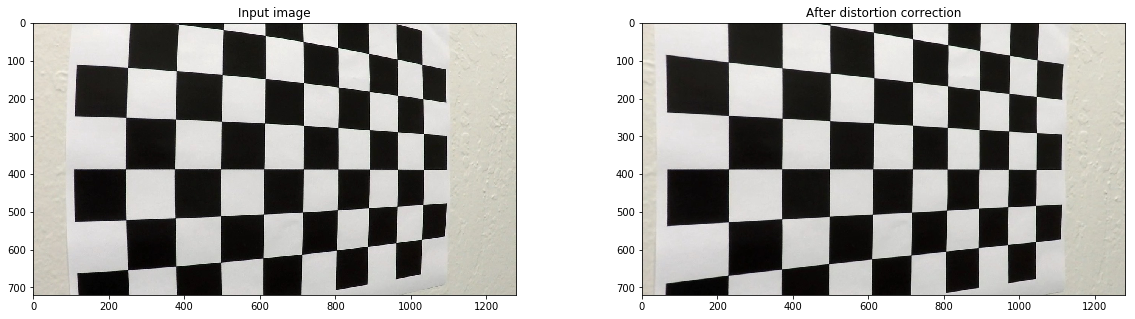

In [4]:
# Show example of corrected calibration image
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
ax[0].imshow(camera_cal_images[15])
ax[0].set_title('Input image')
ax[1].imshow(undistort(camera_cal_images[15]))
ax[1].set_title('After distortion correction')
plt.savefig('./output_images/undistort_output.png')

# Apply a distortion correction to raw images.

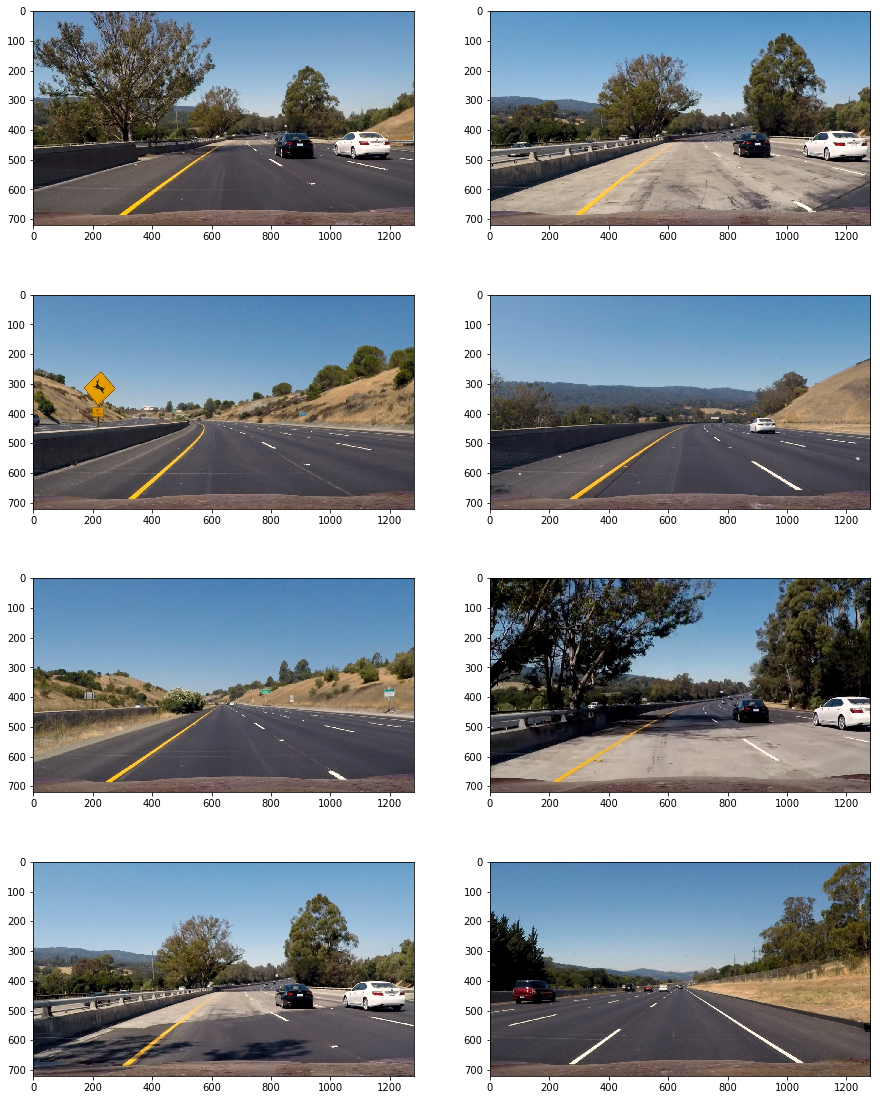

In [5]:
# Load and show all test images (just for debug)
test_images = [mpimg.imread(f) for f in glob.glob('./test_images/*.jpg')]
fig, ax = plt.subplots(nrows=len(test_images)//2, ncols=2, figsize=(15,20))
ax = ax.reshape(-1)
for i, img in enumerate(test_images):
    ax[i].imshow(img)

In [6]:
# Apply callibration and save result to calibrated_images
calibrated_images = [undistort(img) for img in test_images]

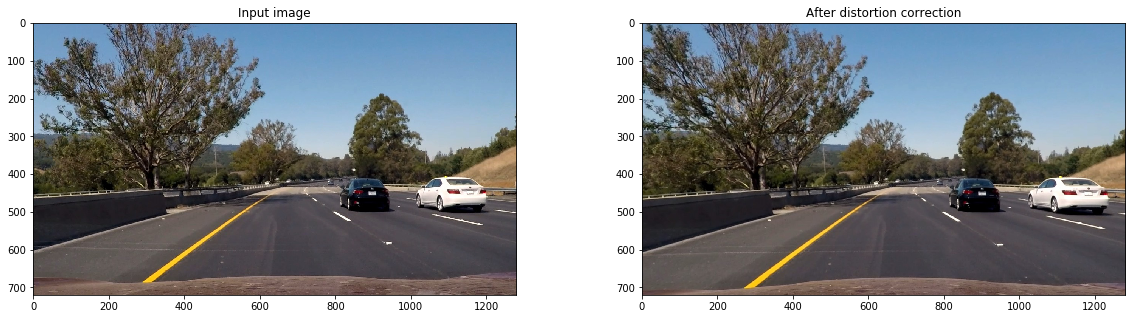

In [7]:
# Save example for writeup
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
ax[0].imshow(test_images[0])
ax[0].set_title('Input image')
ax[1].imshow(calibrated_images[0])
ax[1].set_title('After distortion correction')
plt.savefig('./output_images/test1_calibrated.jpg')

# Apply a perspective transform to rectify binary image ("birds-eye view").


In [8]:
# Define ROI in original coordinates (src) and in destination coordinates.
width = 43
src = [[0, 720], [1280/2-width, 440], [1280/2+width, 440], [1280, 720]]
dst = [[50, 250], [50, 0], [200, 0], [200, 250]]

# Compute forward (M) and backward (Minv) transormation matrices
src, dst = np.float32(src), np.float32(dst)
M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)

# Define two helpers function for forward and backward transormations. Matrices are saved using closure in functions.
def birds_eye(img):
    img = cv2.warpPerspective(img, M, (250, 250))
    # draw rectangle for debug purpose
    # img = cv2.rectangle(img, (74, 0), (181, 250), (0,255,0), 2) 
    return img

def anti_birds_eye(img):
    img = cv2.warpPerspective(img, Minv, (1280, 720))
    return img

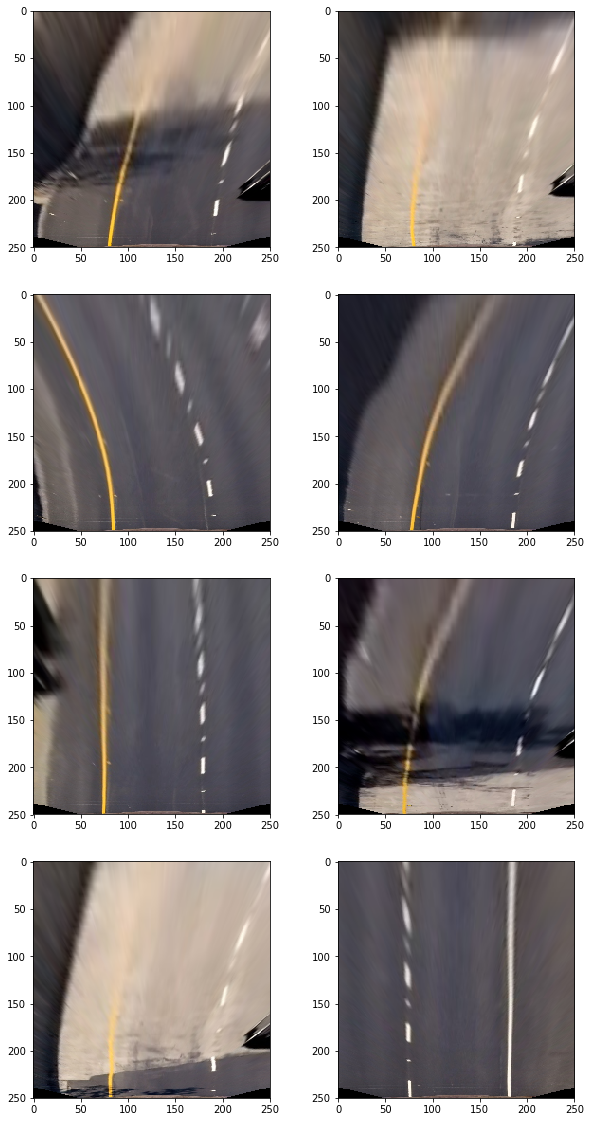

In [9]:
# Visualize test set for debug
fig, ax = plt.subplots(nrows=len(calibrated_images)//2, ncols=2, figsize=(10,20))
ax = ax.reshape(-1)
for i, img in enumerate(calibrated_images):
    ax[i].imshow(birds_eye(img))

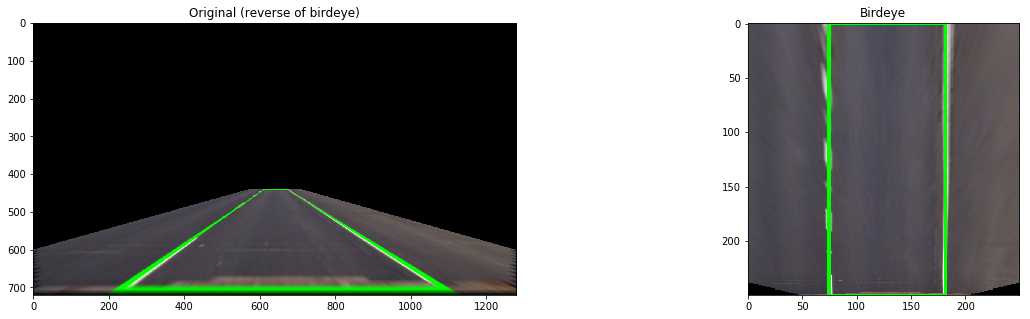

In [10]:
# warped_straight_lines.jpg

# Save example for writeup
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
out = birds_eye(calibrated_images[7])
out = cv2.rectangle(out, (74, 0), (181, 250), (0,255,0), 2)
inp = anti_birds_eye(out)
ax[0].imshow(inp)
ax[0].set_title('Original (reverse of birdeye)')
ax[1].imshow(out)
ax[1].set_title('Birdeye')
plt.savefig('./output_images/warped_straight_lines.jpg')

# Use color transforms, gradients, etc., to create a thresholded binary image

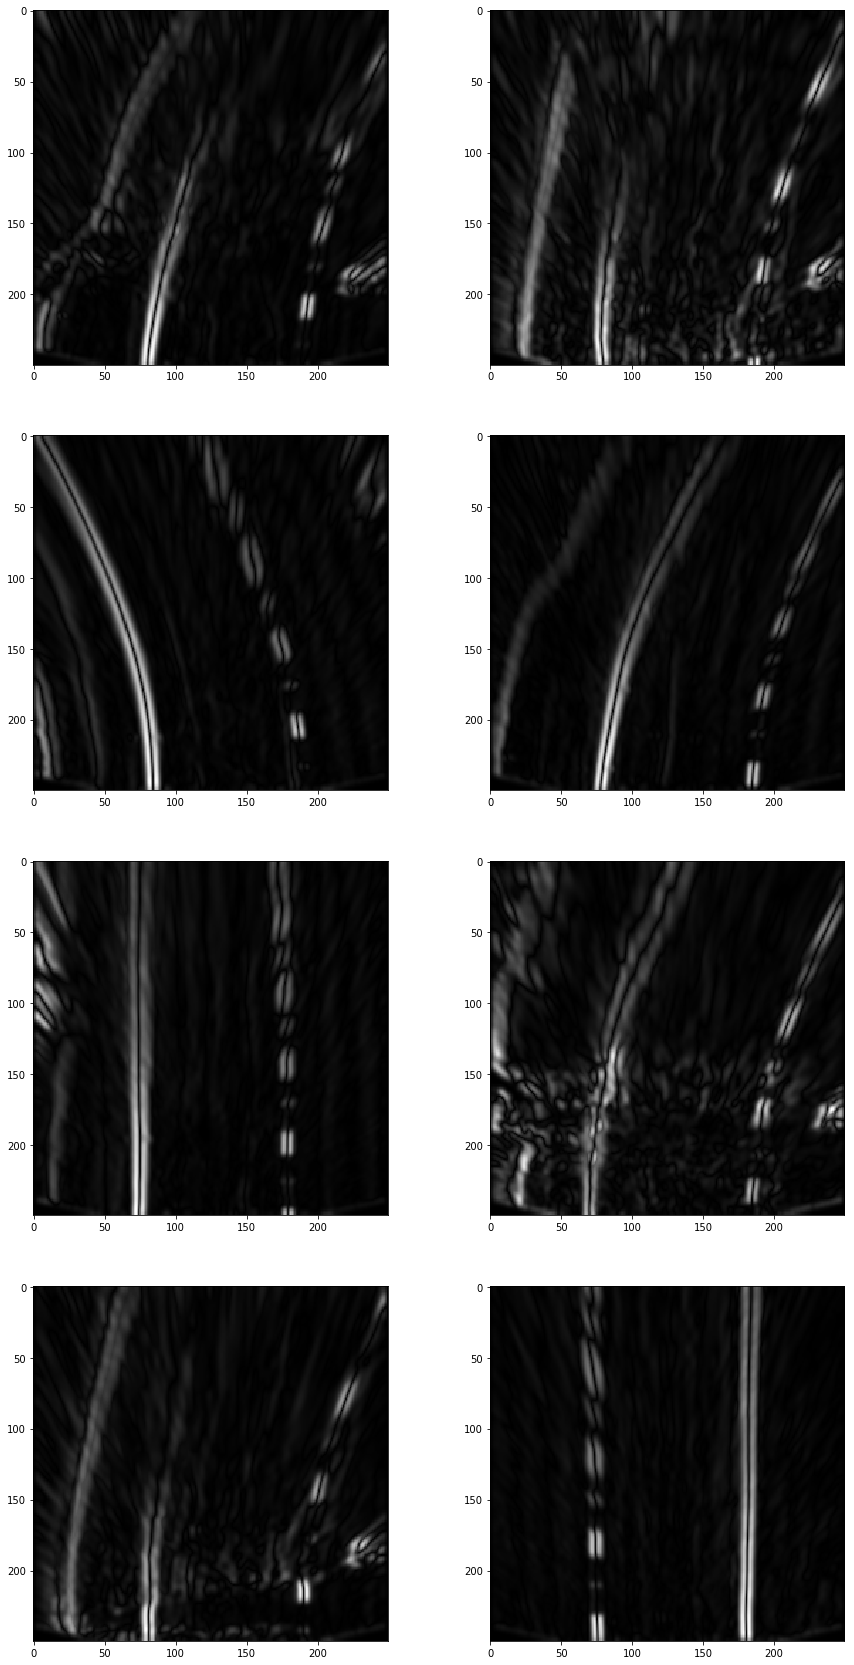

In [11]:
def calc_mask(img, thresh=(0.2, 1.5)):
    
    # Convert to HSV and create yellow mask
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    lower_yellow = np.array([17,80,50])
    upper_yellow = np.array([65,255,255])
    yellow_mask = cv2.inRange(hsv, lower_yellow, upper_yellow)
    
    white_sensitivity = 30
    lower_white = np.array([0,0,255-white_sensitivity])
    upper_white = np.array([255,white_sensitivity,255])
    white_mask = cv2.inRange(hsv, lower_white, upper_white)

    # sobel gray mask
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    gray = clahe.apply(gray)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=15)
    sobelx = np.abs(sobelx)
    sobelx_mask = np.zeros_like(gray)
    sobelx_mask[sobelx < 0.4] = 0
    
    # sobel hls
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS_FULL)
    sobelx_hls = cv2.Sobel(hls[:,:, 2], cv2.CV_64F, 1, 0, ksize=15)
    sobelx_hls = np.abs(sobelx_hls)

    # total
    mask = yellow_mask + white_mask + sobelx + sobelx_hls
    mask = mask / mask.max()
    return mask

fig, ax = plt.subplots(nrows=len(calibrated_images)//2, ncols=2, figsize=(15,30))
ax = ax.reshape(-1)
for i, img in enumerate(calibrated_images):
    img = birds_eye(img)
    ax[i].imshow(calc_mask(img), cmap='gray')

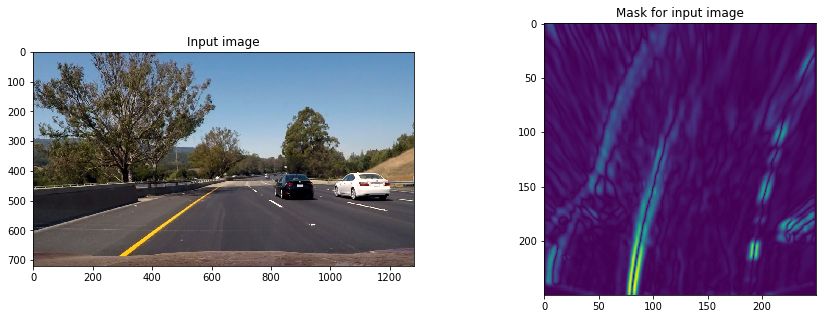

In [12]:
# Save example for writeup
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].imshow(test_images[0])
ax[0].set_title('Input image')
ax[1].imshow(calc_mask(birds_eye(calibrated_images[0])))
ax[1].set_title('Mask for input image')
plt.savefig('./output_images/binary_combo_example.jpg')

# Detect lane pixels and fit to find the lane boundary.

In [13]:
import sklearn.linear_model

_thr = 0.1

def fit_line_model(mask):
    # Create array of targets X, features Y and weights W
    X = []
    Y = []
    W = []
    for x in range(mask.shape[0]):
        for y in range(mask.shape[0]):
            if mask[y, x] > _thr:
                X.append(x)
                Y.append((y**2, y, 1.))
                W.append(mask[y, x])
    # Fit regression
    model = sklearn.linear_model.RANSACRegressor(sklearn.linear_model.LinearRegression(fit_intercept=False), 
                                                 max_trials=50, min_samples=0.9)
    model.fit(Y, X, np.float32(W)**5)
    
    # Return resulting model
    return np.sum(W), model


def line_search(mask, init_from, init_to):
    init_pos = np.argmax(np.sum(mask[150:, init_from:init_to], axis=0)) + init_from
    
    # Construct initial work_mask with buttom part of mask
    work_mask = mask.copy()
    work_mask[:, init_pos+25:] = 0
    work_mask[:, :init_pos-25] = 0
    work_mask[:150] = 0
    work_mask = work_mask * (work_mask > _thr)
    
    # Fit initial polynom
    w, m = fit_line_model(work_mask)

    # Process rest of the mask from down to up of mask
    for i in range(100, -1, -50):
        Y = []
        for y in range(i, i+50):
            Y.append((y**2, y, 1.))
        X = m.predict(Y)
        points = np.int32(list(zip(np.array(X), np.array(Y)[:, 1])))
        for x, y in points:
            work_mask[y, max(0,x-25):max(0, x+25)] = mask[y, max(0, x-25):max(0,x+25)]
        work_mask = work_mask * (work_mask > _thr)
        w, m = fit_line_model(work_mask)

    
    return w, m, work_mask


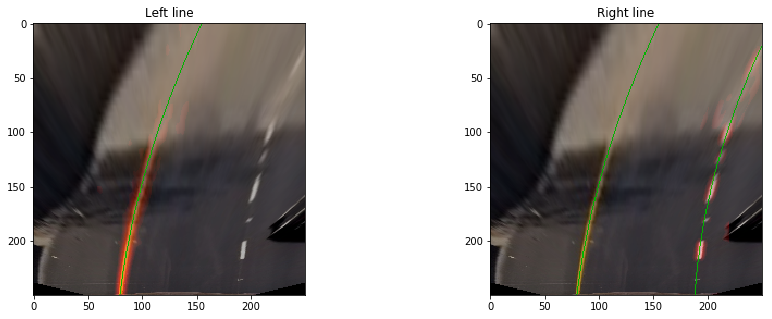

In [14]:
# Visualization
def _draw(img, work_mask, m):
    Y = []
    for y in range(mask.shape[0]):
        Y.append((y**2, y, 1.))
    X = m.predict(Y)
    points = np.int32([list(zip(np.array(X), np.array(Y)[:, 1]))])
    img = cv2.polylines(img, points, False, (0, 255, 0), 1)

    work_mask = np.stack([work_mask, np.zeros_like(work_mask), np.zeros_like(work_mask)], axis=2)
    work_mask = (work_mask * 255).astype('uint8')
    mix = cv2.addWeighted(img, 0.7, work_mask, 0.5, 0)
    return mix


img = birds_eye(calibrated_images[0])
#img = birds_eye(frames[1207])
mask = calc_mask(img)

w, m, work_mask = line_search(mask, 25, 125)
left = _draw(img, work_mask, m)

w, m, work_mask = line_search(mask, 125, 250)
right = _draw(img, work_mask, m)

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].imshow(left)
ax[0].set_title('Left line')
ax[1].imshow(right)
ax[1].set_title('Right line')
plt.savefig('./output_images/color_fit_lines.jpg')

# Radius of curvature

In [15]:
# Define resolution in x and y directions.
mx = 3.5 / 107 
my = 3 / 17

def calc_radius(A, y):
    # scale polynomial from pixels to meters
    a,b = A[:2]
    a = mx / (my ** 2) *a
    b = (mx/my)*b
    y = y * my
    # compute curvature in meters
    return ((1 + (2*a*y + b)**2)**(3/2)) / np.abs(2*a)


# Final image processing

100%|██████████| 8/8 [00:00<00:00, 21.86it/s]


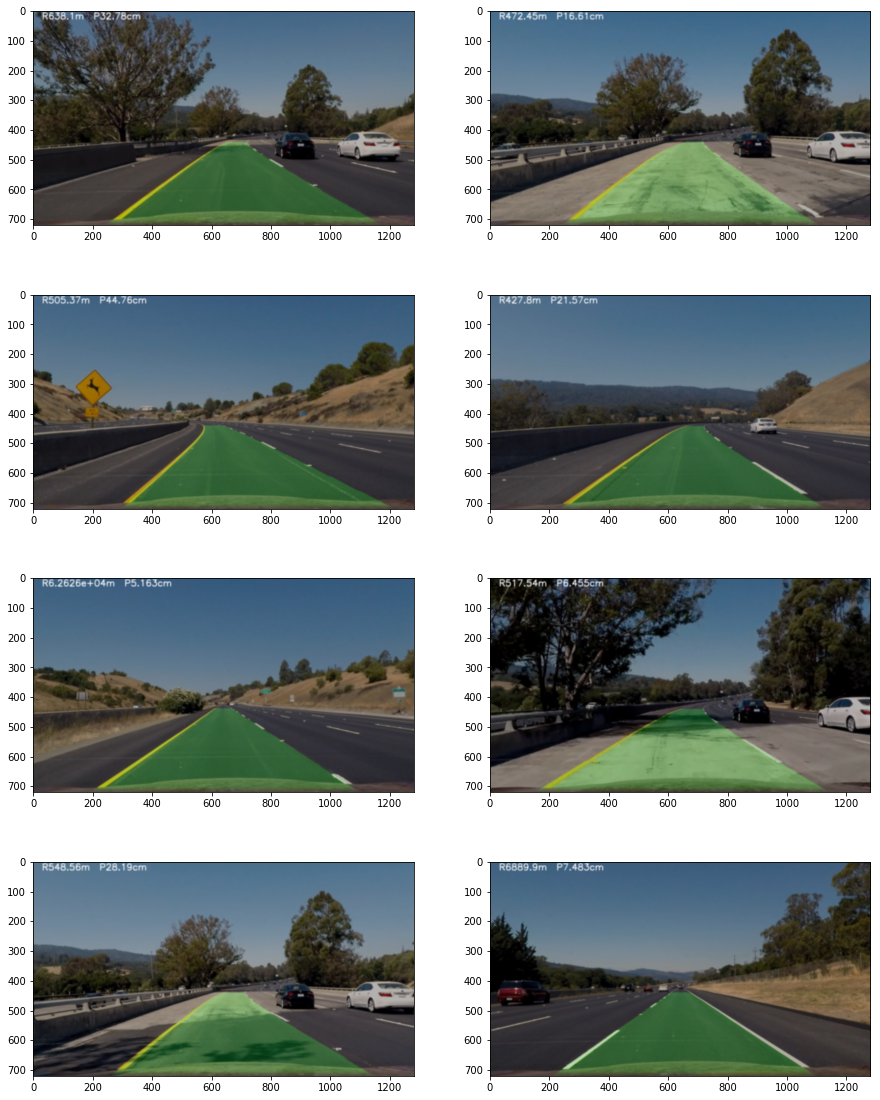

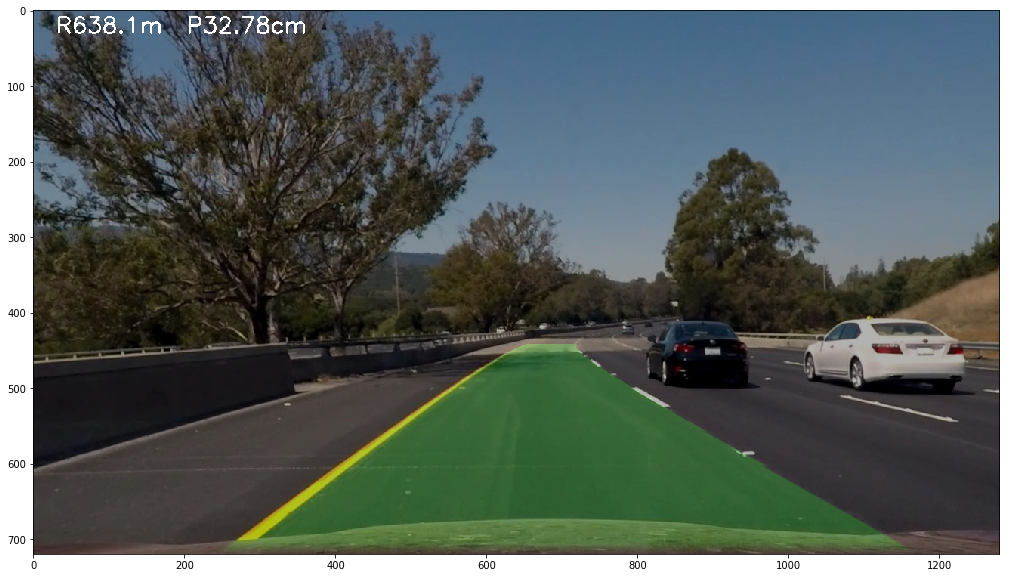

In [16]:
def process_frame(img):
    road = birds_eye(img.copy())
    mask = calc_mask(road)
    y = 240

    w_l, m_l, _ = line_search(mask, 25, 125)
    w_r, m_r, _ = line_search(mask, 125, 225)

    r_l = calc_radius(m_l.estimator_.coef_, y)
    r_r = calc_radius(m_r.estimator_.coef_, y)

    R = (r_l * w_l + r_r * w_r) / (w_l + w_r)
    Y = [[y**2, y, 1.]]
    P = [m_l.predict(Y)[0], m_r.predict(Y)[0]]
    P = (P[0] + P[1])/2 - 125
    P = P * mx * 100
    return m_l, m_r, P, R
    
def draw_result(inp):
    lines, img = inp
    m_l = [l[0] for l in lines]
    m_r = [l[1] for l in lines]
    P = sum([l[2] for l in lines])/len(lines)
    R = sum([l[3] for l in lines])/len(lines)
    
    Y = np.float32([[y**2, y, 1.] for y in range(250)])
    X_l = [m.predict(Y) for m in m_l]
    X_r = [m.predict(Y) for m in m_r]
    lane_img = np.zeros_like(mask)
    for x_l, x_r in zip(X_l, X_r):
        for y, xl, xr in zip(Y[:, 1], x_l, x_r):
            if xl < 0 or xr >= 250:
                continue
            lane_img[int(y), int(xl):int(xr)] += 255. / len(lines)
        
    lane_img = np.uint8(anti_birds_eye(lane_img))
    lane_img = np.stack([np.zeros_like(lane_img), lane_img, np.zeros_like(lane_img)], axis=2)

    img = cv2.addWeighted(img, 0.7, lane_img, 0.2, 0)
    img = cv2.putText(img, f'R{R:.5}m  P{P:.4}cm', (30, 30), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (255, 255, 255), 2)

    return img, R, P


fig, ax = plt.subplots(nrows=len(calibrated_images)//2, ncols=2, figsize=(15,20))
ax = ax.reshape(-1)

lines = [process_frame(i) for i in tqdm(calibrated_images)]
for i, img in enumerate(tqdm(calibrated_images)):
    img, R, P = draw_result(([lines[i]], img))
    ax[i].imshow(img, interpolation='bicubic')
plt.show()

plt.figure(figsize=(20,10))
plt.imshow(draw_result(([lines[0]], calibrated_images[0]))[0])
plt.savefig('./output_images/example_output.jpg')

# Process video

In [17]:
from moviepy.editor import VideoFileClip
video = VideoFileClip('./project_video.mp4')

In [18]:
import multiprocessing
frames = [undistort(img) for img in tqdm(video.iter_frames(), desc='dump', total=1260)]

dump: 100%|██████████| 1260/1260 [00:20<00:00, 60.46it/s]


In [19]:
# I commented this step due to issue with low memory. Instead I load (or save) lines from file.
# with multiprocessing.Pool(2) as pool:
#     lines = list(tqdm(pool.imap(process_frame, frames), total=len(frames), mininterval=3))

In [20]:
import pickle
# with open('./lines.pkl', 'wb') as f:
#     pickle.dump(lines, f)
with open('./lines.pkl', 'rb') as f:
    lines = pickle.load(f)

In [21]:
output = []
for i, frame in tqdm(enumerate(frames), mininterval=3):
    output.append(draw_result(([lines[i]], frame)))

1260it [00:12, 103.21it/s]


In [24]:
import gc
del frames, video
gc.collect()

64

In [22]:
from moviepy.editor import ImageSequenceClip
clip_out = ImageSequenceClip([o[0] for o in output], fps=25)

In [23]:
clip_out.write_videofile('./project_video_out.mp4')

[MoviePy] >>>> Building video ./project_video_out.mp4
[MoviePy] Writing video ./project_video_out.mp4


100%|██████████| 1260/1260 [00:39<00:00, 31.68it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./project_video_out.mp4 



In [ ]:
# Just debug frame from video
plt.figure(figsize=(20, 20))
plt.imshow(output[1207][0])